In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid

import torch
torch.manual_seed(-1)
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

In [2]:
def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

In [3]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.sage1 = SAGEConv(dim_in, dim_h)
        self.sage2 = SAGEConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.sage1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.sage2(h, edge_index)
        return h

    def fit(self, loader, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)

        self.train()
        for epoch in range(epochs+1):
            total_loss = 0
            acc = 0
            val_loss = 0
            val_acc = 0

            # Train on batches
            for batch in loader:
                optimizer.zero_grad()
                out = self(batch.x, batch.edge_index)
                loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
                total_loss += loss.item()
                acc += accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
                loss.backward()
                optimizer.step()

                # Validation
                val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
                val_acc += accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])

            # Print metrics every 10 epochs
            if epoch % 20 == 0:
                print(f'Epoch {epoch:>3} | Train Loss: {loss/len(loader):.3f} | Train Acc: {acc/len(loader)*100:>6.2f}% | Val Loss: {val_loss/len(train_loader):.2f} | Val Acc: {val_acc/len(train_loader)*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

## Pubmed

In [4]:
dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]

/Users/kashyappatel/anaconda3/envs/gnnbctfd/lib/python3.12/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) 

In [5]:
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3


In [6]:
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')


Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [7]:
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)

In [8]:
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

Subgraph 0: Data(x=[419, 500], edge_index=[2, 464], y=[419], train_mask=[419], val_mask=[419], test_mask=[419], n_id=[419], e_id=[464], input_id=[16], batch_size=16)
Subgraph 1: Data(x=[268, 500], edge_index=[2, 311], y=[268], train_mask=[268], val_mask=[268], test_mask=[268], n_id=[268], e_id=[311], input_id=[16], batch_size=16)
Subgraph 2: Data(x=[289, 500], edge_index=[2, 324], y=[289], train_mask=[289], val_mask=[289], test_mask=[289], n_id=[289], e_id=[324], input_id=[16], batch_size=16)
Subgraph 3: Data(x=[189, 500], edge_index=[2, 225], y=[189], train_mask=[189], val_mask=[189], test_mask=[189], n_id=[189], e_id=[225], input_id=[12], batch_size=12)


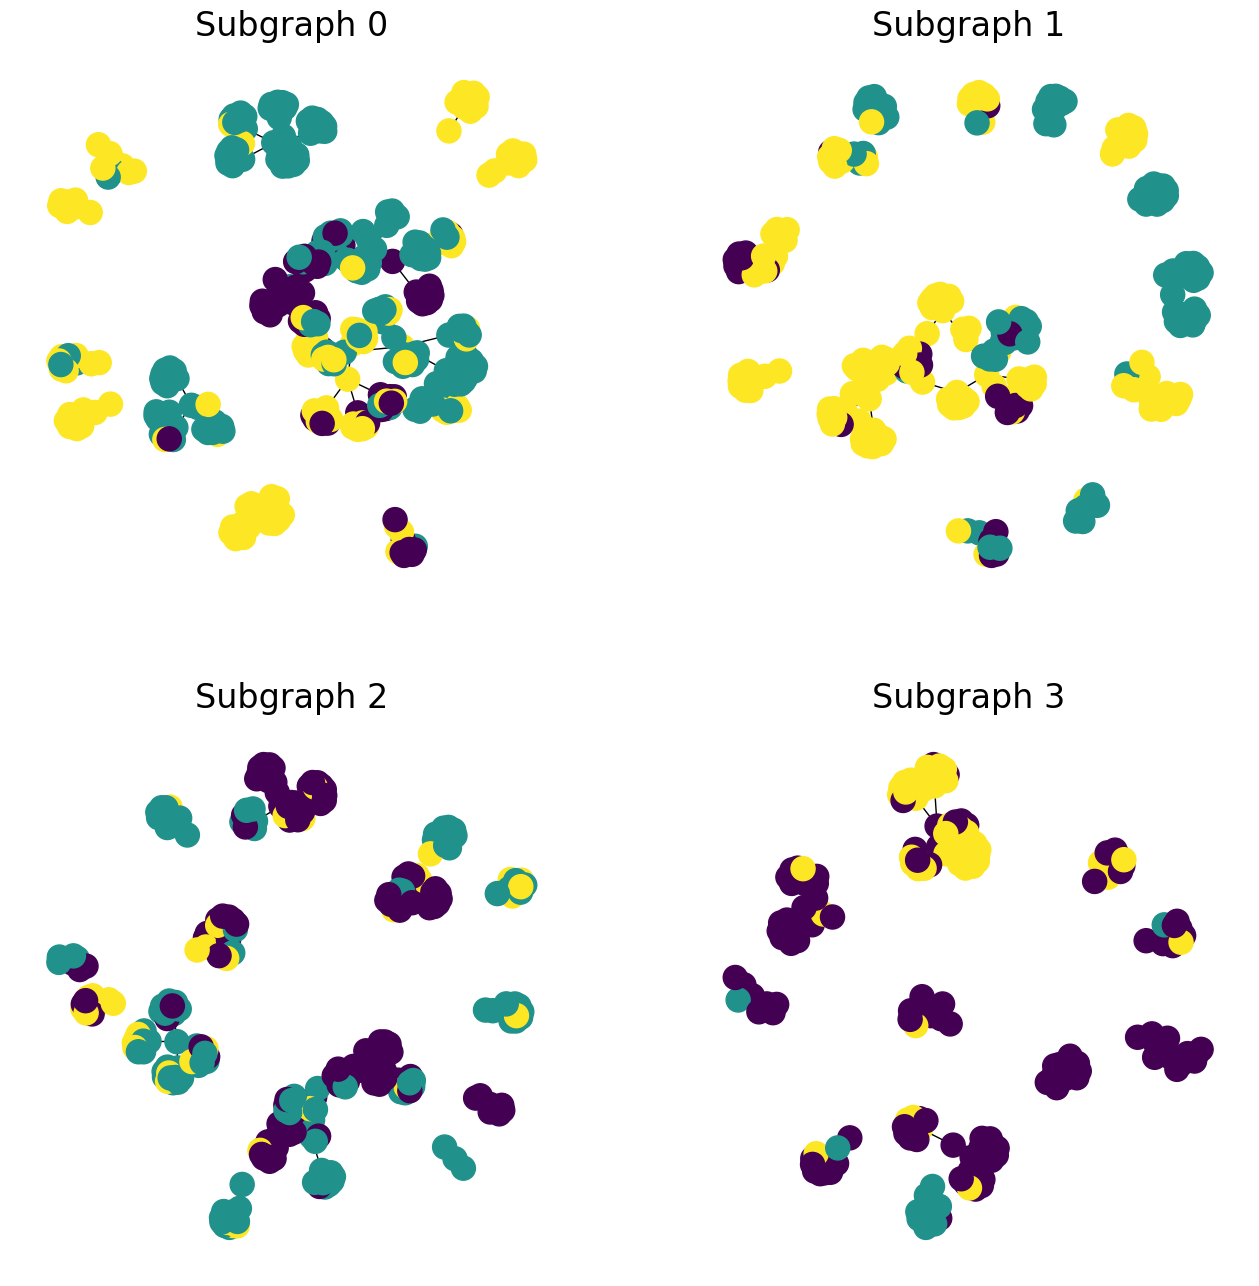

In [9]:
fig = plt.figure(figsize=(16,16))
for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx}', fontsize=24)
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_color=subdata.y,
                    )
plt.show()

In [10]:
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
graphsage

GraphSAGE(
  (sage1): SAGEConv(500, 64, aggr=mean)
  (sage2): SAGEConv(64, 3, aggr=mean)
)

In [11]:
graphsage.fit(train_loader, 200)

Epoch   0 | Train Loss: 0.337 | Train Acc:  28.77% | Val Loss: 1.10 | Val Acc: 35.00%
Epoch  20 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 0.31 | Val Acc: 92.22%
Epoch  40 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 0.48 | Val Acc: 78.77%
Epoch  60 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 83.69%
Epoch  80 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.64 | Val Acc: 71.19%
Epoch 100 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 73.92%
Epoch 120 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.48 | Val Acc: 89.93%
Epoch 140 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.61 | Val Acc: 84.72%
Epoch 160 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.46 | Val Acc: 80.26%
Epoch 180 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.39 | Val Acc: 87.26%
Epoch 200 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.85 | Val Acc: 73.96%


In [12]:
acc = graphsage.test(data)
print(f'GraphSAGE test accuracy: {acc*100:.2f}%')

GraphSAGE test accuracy: 76.20%
